# Massive Data Management -  Regression

##  Solution


## Setup

In [21]:
import os.path
from subprocess import check_call
import importlib
import os
import sys

modules = ["findspark","pyspark"]


print("Checking required modules")
for m in modules:
    torch_loader = importlib.util.find_spec(m)
    if torch_loader is not None:
        print(m," found")
    else:
        print(m," not found, installing")
        if 'google.colab' in sys.modules:
            check_call(["pip", "install", "-q", m])
        else:
            check_call([sys.executable, "-m", "pip", "install", "--user", m])
print("Done!")
#!pip install -q findspark
#  !pip install -q pyspark
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


df = spark.sql('''select 'spark' as hi ''')
df.show()
print("Ready!")

Checking required modules
findspark  found
pyspark  found
Done!
+-----+
|   hi|
+-----+
|spark|
+-----+

Ready!


### Exercise 1

Write a function `load_file(file)` :

- *Name*: `load_file`
- *Input parameters*: 
    - `file`: Path to a local CSV file. We assume that the CSV contains a header and that the schema can be automatically inferred
 
- *Returns*: A Spark dataframe



In [22]:
def load_file(file):
    df = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(file)
    return df

**Test**

First we download the data locally. If this does not work just download the data file from the course web page to the same folder of this notebook and proceed with the next step


In [23]:
import urllib.request
url = "http://gpd.sip.ucm.es/rafa/docencia/mtda/mdm/data/pisaDataClean.csv"
file = "./pisaDataClean.csv"
f = urllib.request.urlretrieve(url,file )


In [24]:
file = "./pisaDataClean.csv"
# Now call to our function
df = load_file(file)
df.printSchema() # show the dataframe schema

root
 |-- RPC: integer (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- MAT: double (nullable = true)
 |-- MAT_FE: double (nullable = true)
 |-- MAT_MA: double (nullable = true)
 |-- REA: double (nullable = true)
 |-- REA_FE: double (nullable = true)
 |-- REA_MA: double (nullable = true)
 |-- SCI: double (nullable = true)
 |-- SCI_FE: double (nullable = true)
 |-- SCI_MA: double (nullable = true)



The data are taken from the **Pisa report**, an international Programme for International Student Assessment. PISA measures 15-year-olds’ ability to use their reading, mathematics and science knowledge and skills to meet real-life challenges.

    - RPC: Country GPD per capita
    - COUNTRY: Country name
    - MAT: Maths average qualification in this country
    - MAT_FE: Maths average qualification for females
    - MAT_MA: Maths average qualification for males
    - REA: Reading average qualification
    - REA_FE: Reading average qualification for females
    - REA_MA: Reading average qualification for males
    - SCI: Science average qualification 	
    - SCI_FE: Science average qualification for females
    - SCI_MA: Science average qualifications  for males
    
    

### Exercise 2

Write a function `histogram` that shows the histogram of a numeric column (have a look to [our notebook](http://gpd.sip.ucm.es/rafa/docencia/mtda/mdm/code/spark_SQL_en.ipynb) for introducing dataframes, Spark SQL and statistics).

- *Name*: `histogram`
- *Input parameters*: 
    - `df`: A Spark dataframe
    - `col`: The column to analyze
    - `bins`: number of bars
    - `color`: color of bars
 
- *Returns*: Nothing, it just shows the histogram


In [25]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
%matplotlib inline

# solution
def histogram(df,col,bins=20,color="red"):
    fig,ax = plt.subplots()
    hist(ax, df.select([col]), bins = bins, color=[color])
    plt.xlabel(col)
    plt.show()

The following code shows the histograms of all the columns excepting *country*

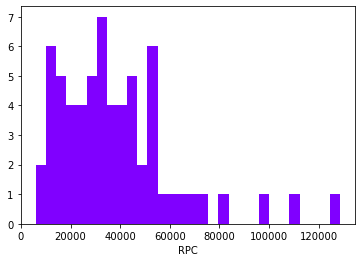

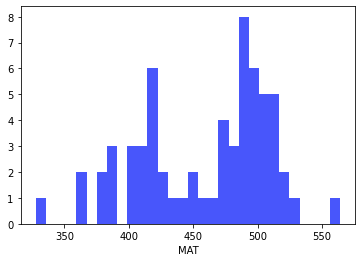

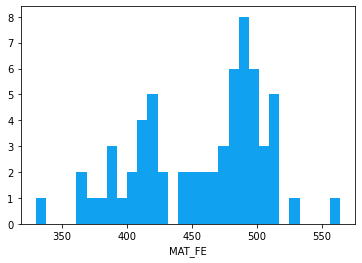

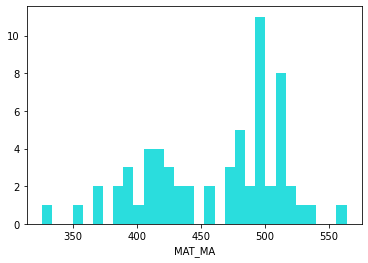

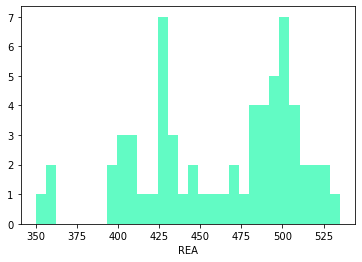

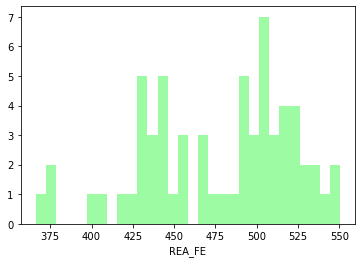

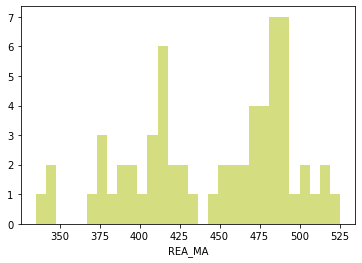

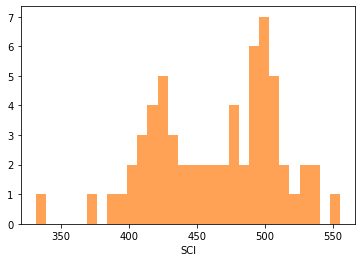

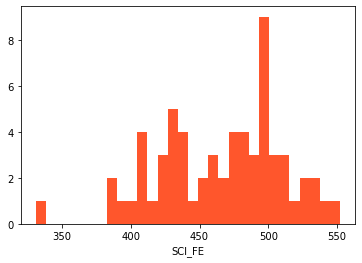

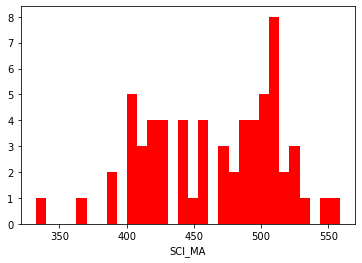

In [26]:
from matplotlib.pyplot import cm
import numpy as np
nocountry = [x for x in df.columns if x not in ['COUNTRY']]
n = len(nocountry)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    histogram(df,nocountry[i],bins=30,color=c)

### Exercise 3

Now our goal is to predict the score in MATH from the GPD per capita (column RPC).
Write code to obtain a new dataframe `df_mat` such that:

  - Only contains columns RPC and MAT (use function [select](https://sparkbyexamples.com/pyspark/select-columns-from-pyspark-dataframe/))

  - Rename column MAT to `label` (use function [withColumnRenamed](https://sparkbyexamples.com/pyspark/pyspark-rename-dataframe-column/)

In [27]:
# solution
df_mat = df.select("RPC","MAT").withColumnRenamed("MAT","label")

In [28]:
df_mat.show(5)

+-----+--------+
|  RPC|   label|
+-----+--------+
|13274| 413.157|
|15757|359.6062|
|21528|409.0333|
|52190|493.8962|
|51936|496.7423|
+-----+--------+
only showing top 5 rows



## Exercise 4

Employ a VectorAssembler in order to convert  df_mat into a new dataframe dfprep that includes a new column `features`, which must be a vector that contains the column "RCP".
The final dataframe must contain only the columns `features` and `label`
  
Hint: Have a look to the "Preparing for ML in Spark" in the regression notebook

In [29]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# names of column to be included in the vector. Usually all the columns except 'label'
vectorcols = [x for x in df_mat.columns if x not in ['label']]

# The method will generate a new column features
assembler = VectorAssembler(
    inputCols=vectorcols,
    outputCol='features')

# apply the method
datawithvector =  assembler.transform(df_mat)

# keep only the columns features and label
dfprepr = datawithvector.select(['features','label'])

# show the first 5 elements
dfprepr.show(5)

+---------+--------+
| features|   label|
+---------+--------+
|[13274.0]| 413.157|
|[15757.0]|359.6062|
|[21528.0]|409.0333|
|[52190.0]|493.8962|
|[51936.0]|496.7423|
+---------+--------+
only showing top 5 rows



## Exercise 5

Now we divide the dataframe `dfprepr` into two dataframes: the train (`train_df`) and the test (`test_df`). The train dataset must contain around the 60% of the data

In [30]:
# split into train and test
splits = dfprepr.randomSplit([0.6, 0.4])
train_df = splits[0]
test_df = splits[1]

# show the first five elements
train_df.show(5)

+---------+--------+
| features|   label|
+---------+--------+
| [5998.0]|419.6635|
| [7462.0]|494.5183|
|[11481.0]|403.8332|
|[12186.0]| 366.818|
|[12812.0]| 380.259|
+---------+--------+
only showing top 5 rows



### Exercise 6 
- Declare the linear regression method. As hyperparameters use `regParam` with value 0.7, and `elasticNetParam` to obtain Lasso regularization (see [here](https://runawayhorse001.github.io/LearningApacheSpark/reg.html))
- Apply the method to the training dataset to obtain the model, that must be called`lrModel`. 

In [31]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression( regParam=0.7, elasticNetParam=1)

# Generate the model
lrModel = lr.fit(train_df)


### Exercise 7

Now we would like to measure the errors, in particular r2 and rmse  (only these). In order to obtain these values apply the model to the test and define two `RegressionEvaluator` object, one for each measure 

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions = lrModel.transform(test_df)



metrics=["r2","rmse"]

evaluatorR2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
evaluatorRMSE = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")

print("R^2", evaluatorR2.evaluate(lr_predictions))
print("rmse", evaluatorRMSE.evaluate(lr_predictions))


R^2 -1.5670306055489038
rmse 76.74053331587967


### Exercise 8
Compute now the RMSE obtained by a RandomForestRegressor. The idea is the same, only changes the regressor method (that must be declared with hyperparameters `numTrees=100, maxDepth=20`). Try to avoid unnecessary repetitions. 
The model must be called `rfr_model`

In [33]:
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor(numTrees=100, maxDepth=20)
rfr_model = rfr.fit(train_df)
rfr_predictions = rfr_model.transform(test_df)

print("rmse", evaluatorRMSE.evaluate(rfr_predictions))

rmse 40.64379556837958


### Exercise 9

Assume a country with a RPC of 10000;  Which will be the score in math according to our model? Choose the model with smaller RMSE (between linear regression and randomforest). Show a confidence interval of 95% using the predicted value and the RMSE

In [14]:
v = lrModel.predict(Vectors.dense([10000]))
rmse =  evaluadorRMSE.evaluate(rfr_predictions)
print("[",v-2*rmse,v+2*rmse,"]")

[ 343.32326974202323 499.68863071914546 ]


### Exercise 10

The dataset contains a small number of rows.  Thus, the split into train and test might have a big influence in the result. This means that the computed RMSE might not be accurate. Write code for repeating 100 times the experiment with the linear regression from the step of the split into division and test on (included). In each loop iteration add the RMSE obtained to the list `rmses`

In [34]:

rmses = []

for i in range(100):
    lr = LinearRegression( regParam=0.7, elasticNetParam=1)
    splits = dfprepr.randomSplit([0.6, 0.4])
    train_df = splits[0]
    test_df = splits[1]

    lrModel = lr.fit(train_df)
    lr_predictions = lrModel.transform(test_df)

    rmses.append(evaluatorRMSE.evaluate(lr_predictions))

Now we show the result

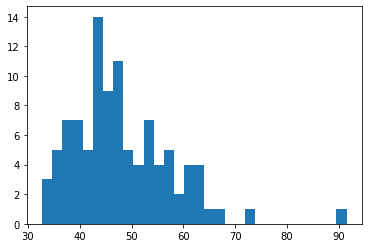

In [16]:
plt.hist(rmses,bins=30)
plt.show()

Mean and standard deviation of the RMSE


In [17]:
import numpy as np
np.mean(rmses),np.std(rmses)

(48.124980244088086, 9.535143051798904)

### Extension: showing the error graphically

Row(features=DenseVector([13162.0]), label=386.1096, prediction=403.8176256666663)
[13162.0]


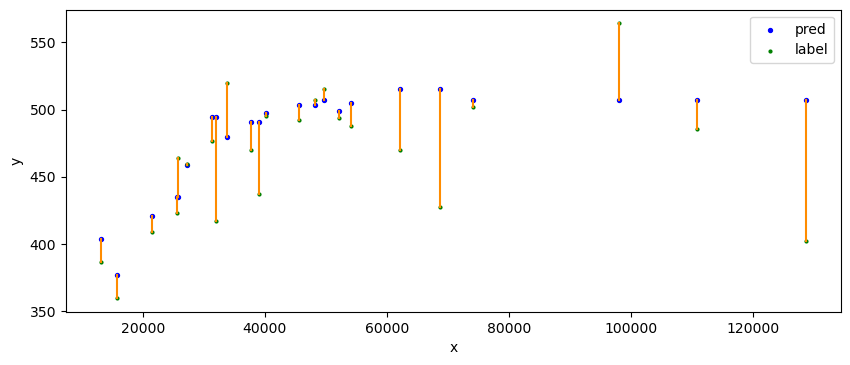

In [48]:
preds = rfr_predictions.collect()
print(preds[0])
print(preds[0][0])

ylabel = [row[1] for row in preds]
ypred = [row[2] for row in preds]
x = [row[0][0] for row in preds]

import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams["font.size"] = 10
figure, ax = plt.subplots(1,figsize=(10, 4),dpi=100)    
for i in range(len(x)):
    plt.plot([x[i],x[i]],[ypred[i],ylabel[i]],color="darkorange")

plt.scatter(x,ypred, color='blue', label="pred",s=8)
plt.scatter(x,ylabel, color='green', label="label",s=4)


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Appendix: learning curve

Question: would we get a smaller error if we had more data?

In [49]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

import numpy as np



x = []
y_train = []
y_test = []
n = 40
# repeat the experiment
for ratio in [i/n for i in range(1,n)]: 
    print(round(ratio,2),end=" ")
    
    
    
    ytr = []
    yte = []
    reps = 100
    for i in range(reps):
        
        splits = dfprepr.randomSplit([ratio, 1-ratio]) 
        train_df = splits[0]
        test_df = splits[1]
        if train_df.count()>0 and test_df.count()>0:
            print(".",end="")
            lr = LinearRegression()
            # Model
            lrModel = lr.fit(train_df)

            # train error
            trainingSummary = lrModel.summary
            ytr.append(trainingSummary.rootMeanSquaredError)

            # test error
            lr_predictions = lrModel.transform(test_df)
            errors = evaluatorRMSE.evaluate(lr_predictions)
            yte.append(errors)   
    if len(yte)>0 and len(ytr)>0:
        y_test.append(np.mean(yte))
        y_train.append(np.mean(ytr))
        x.append(ratio)
        print("train ",round(y_train[-1],2)," test ",round(y_test[-1],2))




0.03 ..................................................................................train  6.28  test  145.01
0.05 .................................................................................................train  14.52  test  81.19
0.07 ....................................................................................................train  22.3  test  70.79
0.1 ....................................................................................................train  24.44  test  66.85
0.12 ....................................................................................................train  29.87  test  60.53
0.15 ....................................................................................................train  31.41  test  58.91
0.17 ....................................................................................................train  34.18  test  56.27
0.2 ....................................................................................................tr

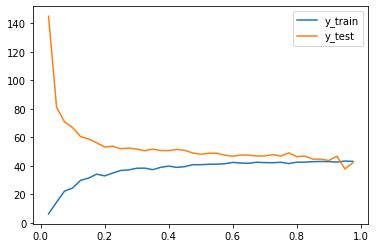

In [50]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(x,y_train,label="y_train")
plt.plot(x,y_test,label="y_test")
plt.legend()
plt.show()

Consequence: 

- the test error will be around 40 (points of score in math) even in the case of more data. 
- Moreover, each prediction will have a confidence interval of 95%  around [p-1.96 RMSE ,p+1.96RMSE], that is around [p-80,p+80]